In [11]:
import sys
sys.path.append('../')

import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the marcia package

%load_ext autoreload
%autoreload 2
from marcia import Kernels
from marcia import Cosmology
from marcia import Data
from marcia import params

%matplotlib inline

## Example set-up for the Gaussian process kernel

In [3]:
%load_ext autoreload
%autoreload 2
from marcia import Kernels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# The kernel class is initialised with the model, parameters and data 
k = Kernels(['SE', 'SE', 'SE'], [1, 1, 1, 1, 1, 1], [np.linspace(0.01, 1, 60), np.linspace(0.01, 1, 100), np.linspace(0.01, 1, 80)])

/workspaces/marcia/Notebooks/../marcia/kernels.py:175: RuntimeWarning: invalid value encountered in multiply
  return np.nan_to_num((2.**(1.-nu)/sp.special.gamma(nu)) * ((np.sqrt(2.*nu) * np.abs(x1-x2))/l_s)**nu * sp.special.kv(nu, (np.sqrt(2.*nu) * np.abs(x1-x2))/l_s)) + np.eye(len(x1))


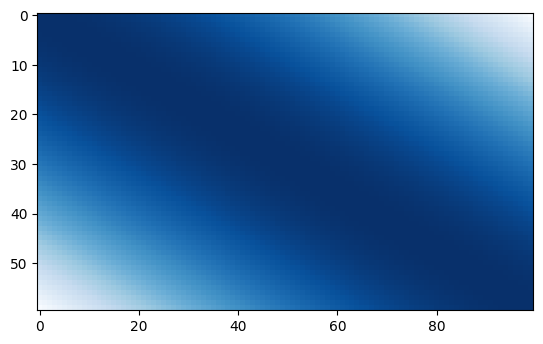

In [10]:
auto_check = k.kernel('M92', [1,2], k.data[1], k.data[1])
cross_check = k.cross_kernel('SE', 'SE',  [1,2], [1,2], k.data[0], k.data[1])
plt.imshow(cross_check, cmap ='Blues') 
plt.show()

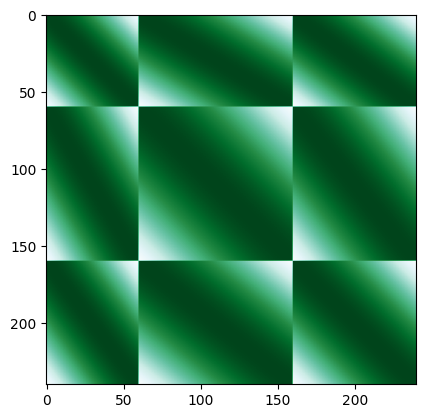

In [11]:
# To plot the full covariance matrix
plt.imshow(k.Cov_Mat(), cmap='BuGn')
plt.show()

## To validate with the data

In [5]:
d = Data(['CC'])
x,y, cov = d()
print(len(x))
hyper_params = [100,10]

k = Kernels(['SE'], hyper_params, [x])

Nuisance parameters are set to default values
31


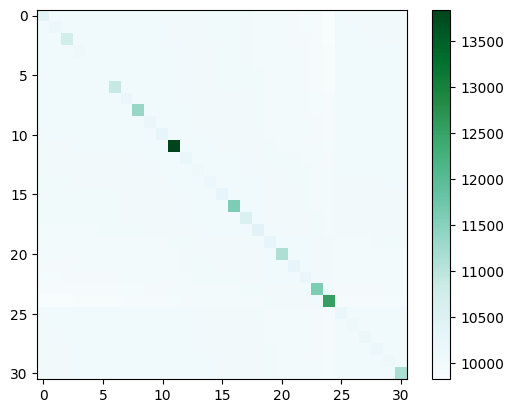

In [6]:

plt.imshow(k.Cov_Mat()+cov, cmap='BuGn')
plt.colorbar()

In [26]:
d2 = Data(['CC', 'SNE'])
x2,y2, cov2 = d2()
hyper_params = [100,100, 10, 10]

Nuisance parameters are set to default values


In [13]:
cov2

array([[ 3.873024e+02,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  1.440000e+02,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  6.864400e+02, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       ...,
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  1.089000e-03,
        -1.054560e-03,  9.361500e-04],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.247100e-04,
         2.704000e-03, -1.185790e-03],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  1.633500e-04,
        -5.137600e-04,  6.241000e-03]])

In [9]:
k2 = Kernels(['SE', 'SE'], hyper_params, list(d2.x.values()))

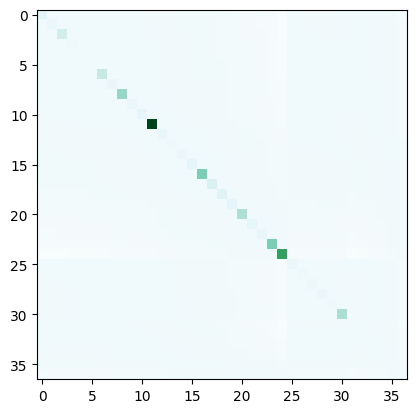

In [10]:
plt.imshow(k2.Cov_Mat() + cov2, cmap='BuGn')

## Validating the generalisations 

In [12]:
import sympy as sy
from sympy.utilities.lambdify import implemented_function
from sympy import lambdify
# from sympy import *

In [13]:
 def basis_fun(model, x, l_s, nu = None):
    """ 
        Defines the basis function for the GP model and returns a vector
        Finally I define only ine single function for the basis function
        This is independent of the amplitude paramter sigma_f
        """
    if model == 'SE':
        return np.exp(- (x**2.)/(2. * l_s**2.))
    
    if model == 'M92':
        A = 48 * np.sqrt(3./35.) * (1./l_s**2.)**(5./4.) * x**2. * sp.special.kv(2., 3. * np.abs(x) / l_s) / np.pi 
        return A
    
    if model == 'M72':
       A = np.sqrt(2./5.) * 7**(3./4.) * np.exp(- np.sqrt(7.) * np.abs(x) / l_s) * (1./l_s**2.)**(1./4.) * np.abs(x) * (1. + l_s / np.sqrt(7. * x**2.))/ l_s
       return A
    
    if model == 'Mnu':
        A = (nu / (2. * np.pi * l_s**2.))**(1./8.) * (sp.special.gamma(nu/2. - 1./4.)/sp.special.gamma(nu/2. + 1./4.))**(1./2.) * (sp.special.gamma(nu + 1./2.)/sp.special.gamma(nu))**(1./4.)
        B = 2.**(5./4. - nu/2.) / sp.special.gamma(nu/2. - 1./4.)
        C = (2. * nu)**(1./2.) * np.sqrt(x**2.) / l_s
        return A**2. * B * C**(nu/2. - 1./4.) * sp.special.kv(nu/2. - 1./4., C)

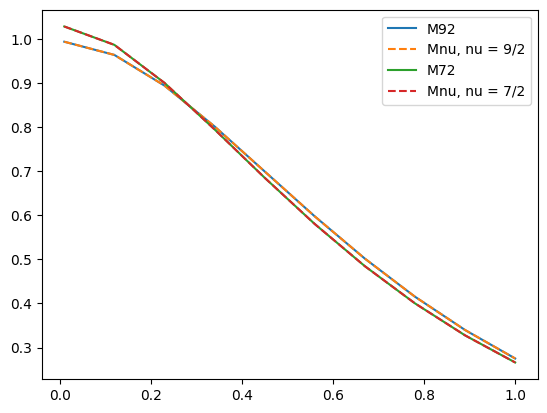

In [14]:
x1_list = np.linspace(0.01, 1.0, 10)
x2_list = np.linspace(0.1, 0.6, 5)
# M92
nu = 9./2.
plt.plot(x1_list, basis_fun('M92',x1_list, 1), label = 'M92')
plt.plot(x1_list, basis_fun('Mnu', x1_list, 1, nu), label = 'Mnu, nu = 9/2', ls = '--')    

# M72
nu  = 7./2.
plt.plot(x1_list, basis_fun('M72',x1_list, 1, ), label = 'M72')
plt.plot(x1_list, basis_fun('Mnu', x1_list, 1, nu), label = 'Mnu, nu = 7/2', ls = '--')    

plt.gca().legend()
plt.show()


In [5]:
# To test the time taken to evaluate the basis function
""" seemingly the Mnu is the slower one   """
%timeit basis_fun('M92',x1_list, 1)
%timeit basis_fun('Mnu',x1_list, 1, 9./2.)
%timeit basis_fun('M72',x1_list, 1)
%timeit basis_fun('Mnu',x1_list, 1, 7./2.)

16.2 µs ± 742 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
20.7 µs ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
15.9 µs ± 996 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
18.5 µs ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
t = x1_list[:,None] - x2_list[None,:]
%timeit sp.integrate.quad(lambda x: basis_fun('M72',x, 1 ) * basis_fun('M72',2-x, 2 ), 0, 1)

272 µs ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
# To integrate the product of two basis functions and lambdafy it as function of l1 and l2
def basis_fun_int(model1, model2, l1, l2, nu1 = None, nu2 = None):
    """
        Provides the integral of the product of two basis functions as a function of the length scales
        """
    l1 = sy.Symbol('l1')
    l2 = sy.Symbol('l2')
    x = sy.Symbol('x')
    f = implemented_function('f', basis_fun(model1, x, l1, nu1))
    
    prod = basis_fun(model1, x1_list, l1, nu1) * basis_fun(model2, x - x1_list, l2, nu2)
    return sy.lambdify([l1, l2], sy.integrate(prod, (x, 0, 1)), 'numpy')


In [47]:
l1 = sy.Symbol('l1')
l2 = sy.Symbol('l2')
u = sy.Symbol('u')
t = sy.Symbol('t')

def integrand(u, t, l1, l2):
    return basis_fun('M72',u, l1 ) * basis_fun('M72',t-u, l2 )

f = implemented_function('f', lambda t,l1,l2: sp.integrate.quad(integrand, -sp.inf, sp.inf, args=(t,l1,l2)))
ff = lambdify([t, l1, l2], f( t, l1,l2), 'numpy')

In [21]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool
import itertools

from scipy.special import gamma, kv
from numba import jit

def gMdef(tau, nu, sigma1, l1):
    if nu == 5/2:
        return 48 * np.sqrt(3./35.) * (1./l1**2.)**(5./4.) * tau**2. * sp.special.kv(2., 3. * np.abs(tau) / l1) / np.pi
    elif nu == 7/2:
        A = np.sqrt(2./5.) * 7**(3./4.) * np.exp(- np.sqrt(7.) * np.abs(tau) / l1) * (1./l1**2.)**(1./4.) * np.abs(tau) * (1. + l1 / np.sqrt(7. * tau**2.))/ l1
        return A


def gMMdef(tau, u, nu1, sigma1, l1, nu2, sigma2, l2):
    gM1 = gMdef(u, nu1, sigma1, l1)
    gM2 = gMdef(tau - u, nu2, sigma2, l2)
    return gM1 * gM2

def KcMM(l1_values, l2_values, tau_values):
    
    integrals = np.zeros((len(tau_values), len(l2_values), len(l1_values)))

    for i, tau in enumerate(tau_values):
        for j, l2 in enumerate(l2_values):
            for k, l1 in enumerate(l1_values):
                integrand = lambda u: gMMdef(tau, u, 7/2, 1.0, l1, 7/2, 1.0, l2)
                integral, _ = quad(integrand, -np.inf, np.inf, epsabs=1e-8, epsrel=1e-8, limit=100)
                integrals[i, j, k] = integral
    
    return RegularGridInterpolator((tau_values, l2_values, l1_values), integrals, bounds_error=False, fill_value=None)

def KcMM2(nu1, nu2, l1, l2):
    apprange = np.linspace(-10, 10, 100)  # Adjust the range as needed
    integrals = []
    
    for tau in apprange:
        integrand = lambda u: gMMdef(tau, u, nu1, 1, l1, nu2, 1, l2)
        integral, _ = quad(integrand, -np.inf, np.inf, epsabs=1e-3, epsrel=1e-3, limit=200)
        integrals.append(integral)
    
    return interp1d(apprange, integrals, kind='cubic')

from joblib import Parallel, delayed

def KcMM3(nu1, nu2, l1, l2):
    apprange = np.linspace(-10, 10, 100)  # Adjust the range as needed
    integrals = np.zeros_like(apprange)
    
    def integrand(u, tau):
        return gMMdef(tau, u, nu1, 1, l1, nu2, 1, l2)

    def integrate(tau):
        integral, _ = quad(integrand, -np.inf, np.inf, args=(tau,), epsabs=1e-3, epsrel=1e-3, limit=200)
        return integral

    integrals = Parallel(n_jobs=4)(delayed(integrate)(tau) for tau in apprange)

    return interp1d(apprange, integrals, kind='cubic')


In [9]:
l1 = np.linspace(0.01, 20, 10)
l2 = np.linspace(0.01, 20, 10)
apprange = np.linspace(-10, 10, 20)  # Adjust the range as needed
interpolator = KcMM(l1, l2, tau_values=apprange)
# Evaluate the interpolator at specific points
tau = 0.5
l2_ex = 1.0
l1_ex = 2.0

interpolated_value = interpolator([tau, l2_ex, l1_ex])
print(interpolated_value)

[0.43487508]


In [6]:
def _sp_(tau,l1):
    return sp.special.kv(2., 3. * np.abs(tau) / l1)

@jit(nopython=True)
def gMdef_52(tau, l1):
    return 48 * np.sqrt(3./35.) * (1./l1**2.)**(5./4.) * tau**2.

@jit(nopython=True)
def gMdef_72(tau, l1):
    return np.sqrt(2./5.) * 7**(3./4.) * np.exp(- np.sqrt(7.) * np.abs(tau) / l1) * (1./l1**2.)**(1./4.) * np.abs(tau) * (1. + l1 / np.sqrt(7. * tau**2.))/ l1

def gMdef_v1(tau, nu, sigma1, l1):
    if nu == 5/2:
        return  gMdef_52(tau,l1)* _sp_(tau,l1) / np.pi
    elif nu == 7/2:
        return gMdef_72(tau,l1)


def gMMdef_v1(tau, u, nu1, sigma1, l1, nu2, sigma2, l2):
    gM1 = gMdef_v1(u, nu1, sigma1, l1)
    gM2 = gMdef_v1(tau - u, nu2, sigma2, l2)
    return gM1 * gM2


def integrand(params):
    tau, l2, l1 = params
    gMMdef_integrand = lambda u: gMMdef_v1(tau, u, 7/2, 1.0, l1, 7/2, 1.0, l2)
    integral, _ = quad(gMMdef_integrand, -np.inf, np.inf, epsabs=1e-8, epsrel=1e-8, limit=100)
    return integral

def KcMM_v1(l1_values, l2_values, tau_values):
    integrals = np.zeros((len(tau_values), len(l2_values), len(l1_values)))
    params = list(itertools.product(tau_values, l2_values, l1_values))
    with Pool() as pool:
        integrals = pool.map(integrand, params)
    integrals = np.array(integrals).reshape((len(tau_values), len(l2_values), len(l1_values)))   
    return RegularGridInterpolator((tau_values, l2_values, l1_values), integrals, bounds_error=False, fill_value=None)

In [49]:
l1 = np.linspace(0.01, 20, 100)
l2 = np.linspace(0.01, 20, 100)
apprange = np.linspace(-10, 10, 100)  # Adjust the range as needed
interpolator = KcMM_v1(l1, l2, tau_values=apprange)

# To save the interpolator
import pickle
with open('KcMM_v1.pck', 'wb') as f:
    pickle.dump(interpolator, f)

# Evaluate the interpolator at specific points
tau = 0.5
l2_ex = 1.0
l1_ex = 2.0


interpolated_value = interpolator([tau, l2_ex, l1_ex])
print(interpolated_value)

[0.85215139]


In [50]:
with open('KcMM_v1.pck', 'rb') as f:
    interpolator2 = pickle.load(f)

interpolated_value = interpolator2([tau, l2_ex, l1_ex])
print(interpolated_value)

[0.85215139]


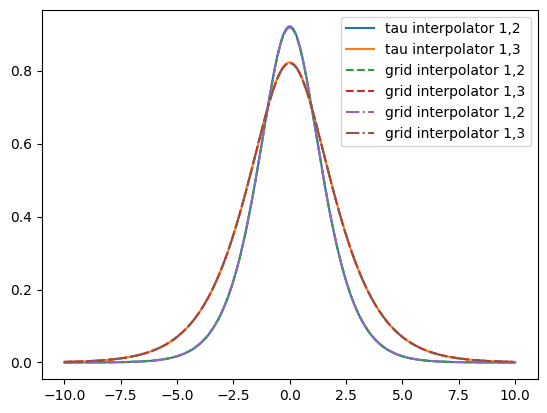

In [51]:
tau_list = np.linspace(-10, 10, 200)
plt.plot(tau_list, KcMM2(7./2., 7./2., 1, 2)(tau_list), label = 'tau interpolator 1,2')

plt.plot(tau_list, KcMM2(7./2., 7./2., 1, 3)(tau_list), label = 'tau interpolator 1,3')

plt.plot(tau_list, [interpolator([x,1,2]) for x in tau_list], label = 'grid interpolator 1,2' , ls = '--')
plt.plot(tau_list, [interpolator([x,1,3]) for x in tau_list], label = 'grid interpolator 1,3', ls = '--')

plt.plot(tau_list, [interpolator2([x,1,2]) for x in tau_list], label = 'grid interpolator 1,2' , ls = '-.')
plt.plot(tau_list, [interpolator2([x,1,3]) for x in tau_list], label = 'grid interpolator 1,3', ls = '-.')

plt.gca().legend()
plt.show()

In [30]:
# convert milliseconds to seconds
%timeit KcMM2(7./2., 7./2., 4, 1)(tau_list)

510 ms ± 243 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit KcMM3(7./2., 7./2., 1, 2)(tau_list)

232 ms ± 9.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# convert milliseconds to seconds
%timeit [interpolator([x,1,2]) for x in tau_list]

30.6 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
3000/3600

0.8333333333333334

## To validate the new kernel 

In [72]:
import sys
sys.path.append('../')
# %load_ext autoreload
# %autoreload 2
from marcia import GPconfig
from marcia import Kernels
from marcia import Data

from marcia.backend import kernel  as kernel 

MTGP = GPconfig.GPConfig('../marcia/GPconfig.ini').__dict__
MTGP['models']
MTGP['n_points']

100

In [73]:
d = Data(['CC', 'SNE'])
x,y, cov = d()
print(len(x))
hyper_params = [100,10]

Nuisance parameters are set to default values
37


In [74]:
data_ker = list(d.x.values())
K = Kernels(data_ker)

Number of tasks: 2
Number of datasets: 2
Kernels: ['SE', 'SE']
